# CMA/ES - GORGO 11 SEQUENTIAL - Hierarchical 1th try: EM Fits MSE scaled

**HIERARCHICAL NETWORK**

Scaled EM Fits

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

import fitexperiment_sequential
from plots_fitexperiment_sequential import PlotsFitExperimentSequential

In [3]:
from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


## Reload data

In [4]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_gorgo11sequential_1try_emfitmsescaled_Mratiosigxsigbaselapsealpha_rep3_181018/
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-8b9f09b8-c8e0-4201-a135-321eff2f4cf1.npy').item()


/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_gorgo11sequential_1try_emfitmsescaled_Mratiosigxsigbaselapsealpha_rep3_181018


In [5]:
# dataio = DataIO(label='cmaes_gorgo11seq', 
#                 calling_function='', 
#                 output_folder='./outputs/')

In [6]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [7]:
parameter_names_sorted

['M', 'alpha', 'lapse_rate', 'ratio_hierarchical', 'sigma_baseline', 'sigmax']

In [8]:
metric = 'dist_emfitscaled'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])

df_all_fits.loc[:, metric + "_log"] = np.log(df_all_fits[metric])
df_all_fits.loc[:, metric + "_log10"] = np.log10(df_all_fits[metric])

In [9]:
# Fix M and ratio_conj
ratio_hierarchical, M_lower, M_higher = utils.fix_ratiohierarchical(
    df_all_fits['M'], df_all_fits['ratio_hierarchical'])
df_all_fits.loc[:, 'ratio_hierarchical'] = ratio_hierarchical
df_all_fits.loc[:, 'M_lower'] = M_lower
df_all_fits.loc[:, 'M_higher'] = M_higher

In [10]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 200

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

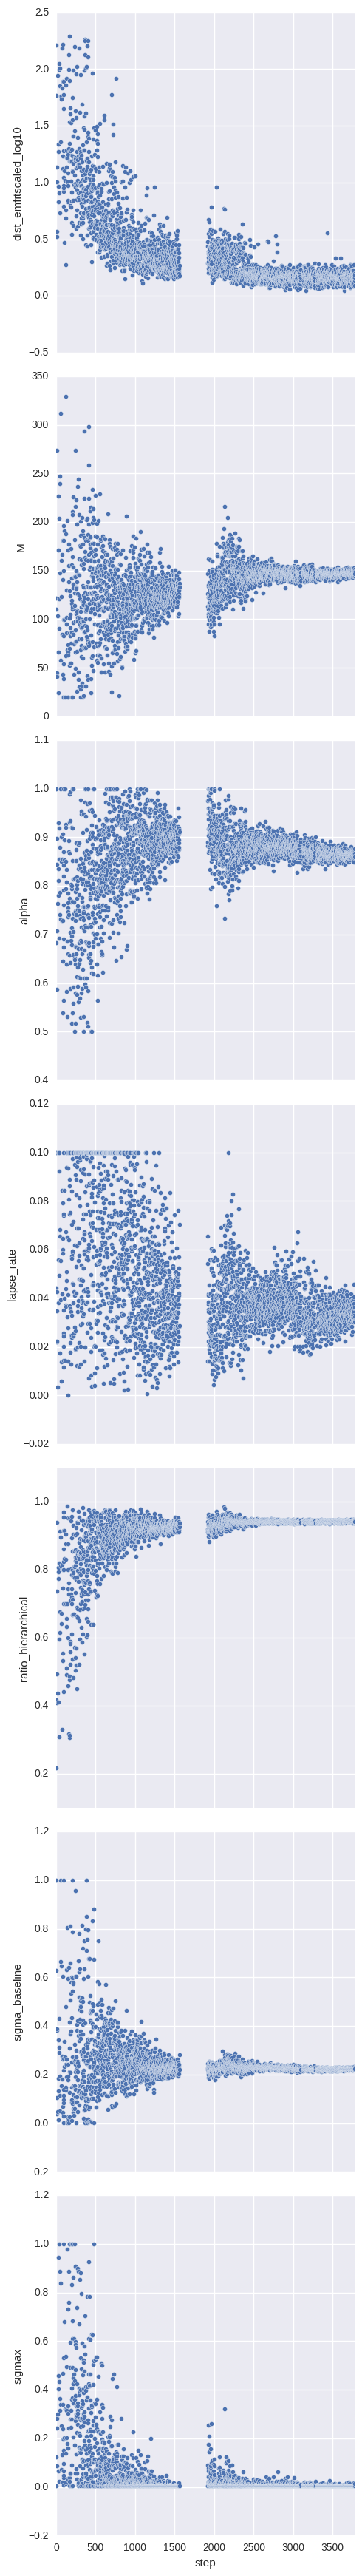

In [11]:
# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=[metric + "_log10"] + parameter_names_sorted,
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))
# dataio.save_current_figure('cmaes_traj_{label}_{unique_id}.pdf')

# Check parameters effects
# sns.pairplot(df_best_fits,
#              x_vars=parameter_names_sorted,
#              y_vars=[metric],
#             )



In [12]:
# Filter the start of steps only
df_cmaes_traj = df_best_fits[df_best_fits['step'] > 2000]
# result_to_color = np.array(df_cmaes_traj['dist_emfitscaled'])
result_to_color = np.array(df_cmaes_traj['step'])
result_to_color = np.log(result_to_color)

text = ['> %s' % (x) for x in result_to_color]

trace1 = go.Scatter3d(
        x = df_cmaes_traj['M'],
        y = df_cmaes_traj['lapse_rate'],
        z = df_cmaes_traj['sigma_baseline'],
        text = text,
        mode = 'markers',
        marker = go.Marker(
            color = result_to_color,
            size = 8,
            colorscale='Viridis',
            opacity=0.7
        )
    )
data = [trace1]
layout = go.Layout(
    title='Landscape for NLL92',
    autosize=False,
    width=700,
    height=700,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
    scene=go.Scene(
        xaxis=go.XAxis(
            title='M',
        ),
        yaxis=go.YAxis(
            title='lapse_rate',
        ),
        zaxis=go.ZAxis(
            title='sigma_baseline',
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Check parameters values obtained

In [13]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).head(1).median().to_dict()

# df_bestparams = df_best_fits.sort_values(by='dist_emfitscaled').head(1).median().to_dict()

df_bestparams

{'M': 146.5856062266179,
 'M_higher': 138.0,
 'M_lower': 8.0,
 'alpha': 0.8589212463712191,
 'dist_emfitscaled': 1.5247503003072316,
 'dist_emfitscaled_log': 0.42183065914947177,
 'dist_emfitscaled_log10': 0.18319872756622704,
 'lapse_rate': 0.030176410977034693,
 'ratio_hierarchical': 0.9414294046487433,
 'sigma_baseline': 0.2246091799348813,
 'sigmax': 0.014186791725119009,
 'step': 3779.0}

In [14]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_sequential_allmetrics',
                             inference_method='none',
                             experiment_id='gorgo11_sequential',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             alpha=1.,
                             num_samples=100,
                             code_type='hierarchical',
                             type_layer_one='feature',
                             output_both_layers=None,
                             normalise_weights=1,
                             ratio_hierarchical=0.5,
                             normalise_gain=None,
                             threshold=1.0,    
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             filter_datapoints_size=500, 
                             filter_datapoints_selection='random'
                             )

experiment_parameters.update(df_bestparams)
for key in experiment_parameters:
    if 'M' in key:
        experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    results = experiment_launcher.all_vars['all_outputs_data']

In [15]:
plots_fit_exp = PlotsFitExperimentSequential(fit_exp)

Doing Sequential plots for gorgo11_sequential. 
Hist 1, Fig6 1, Fig7 1


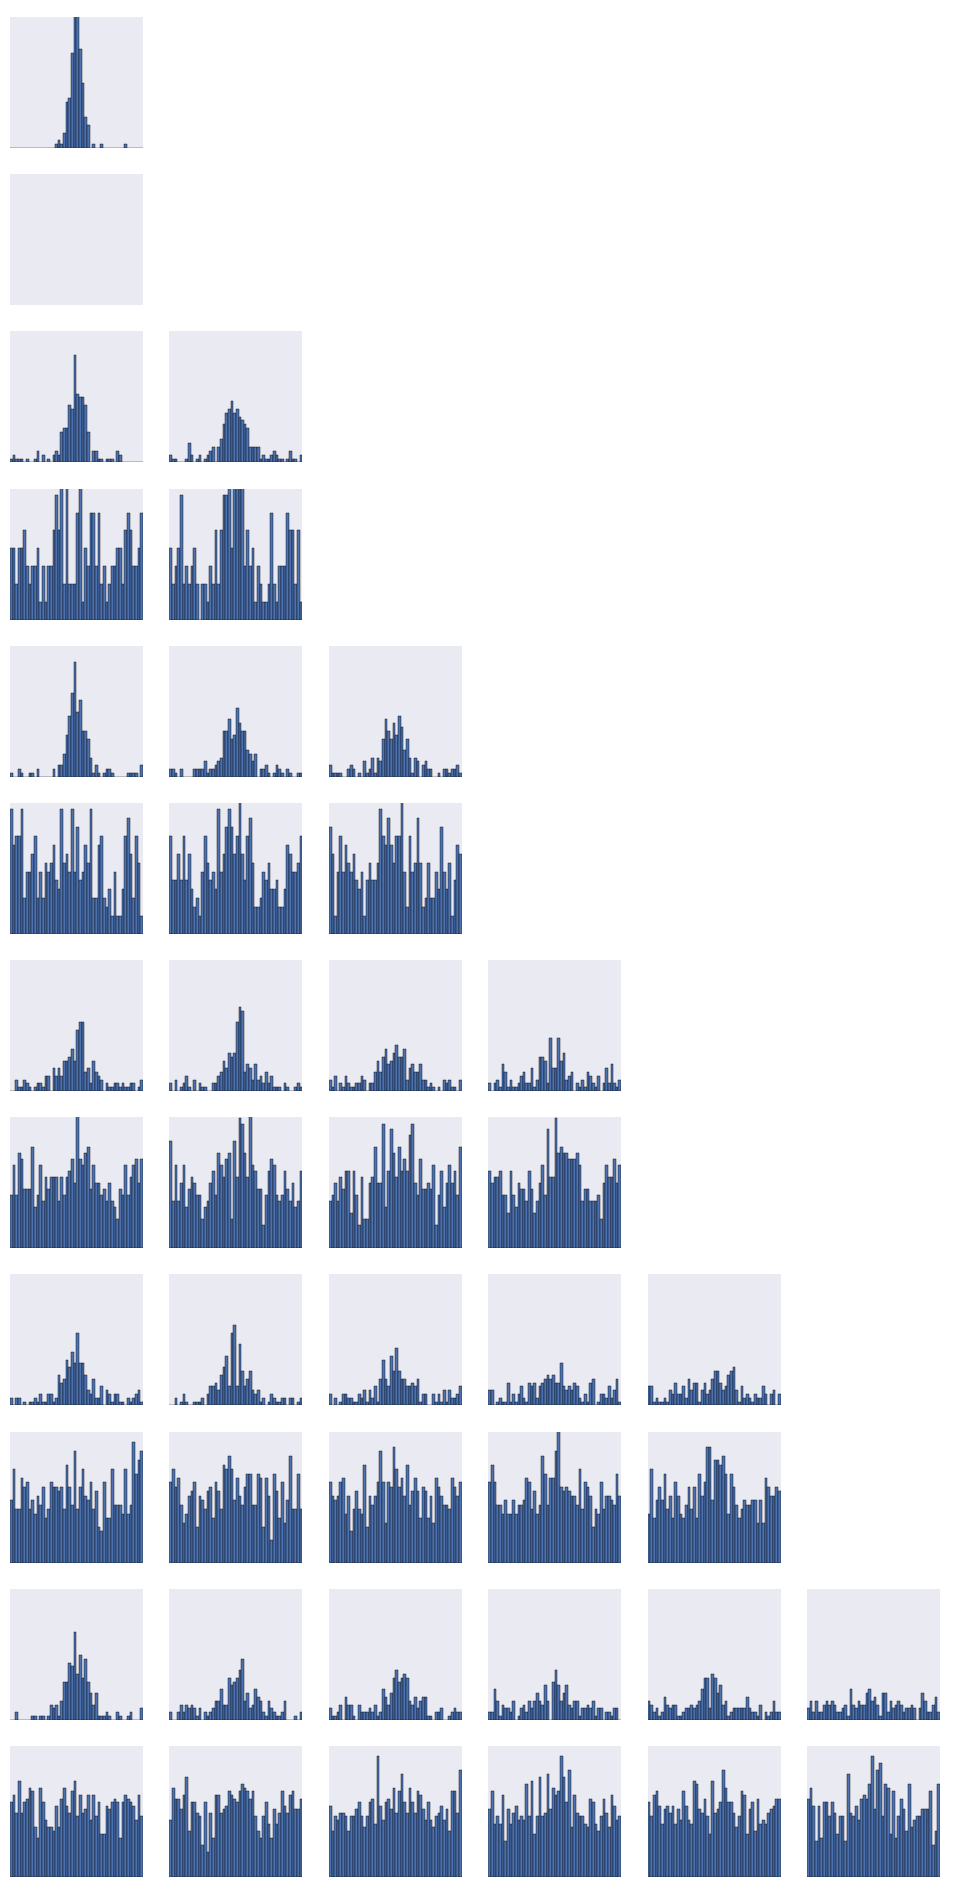

In [16]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig2 = plots_fit_exp.plots_histograms_errors_triangle()

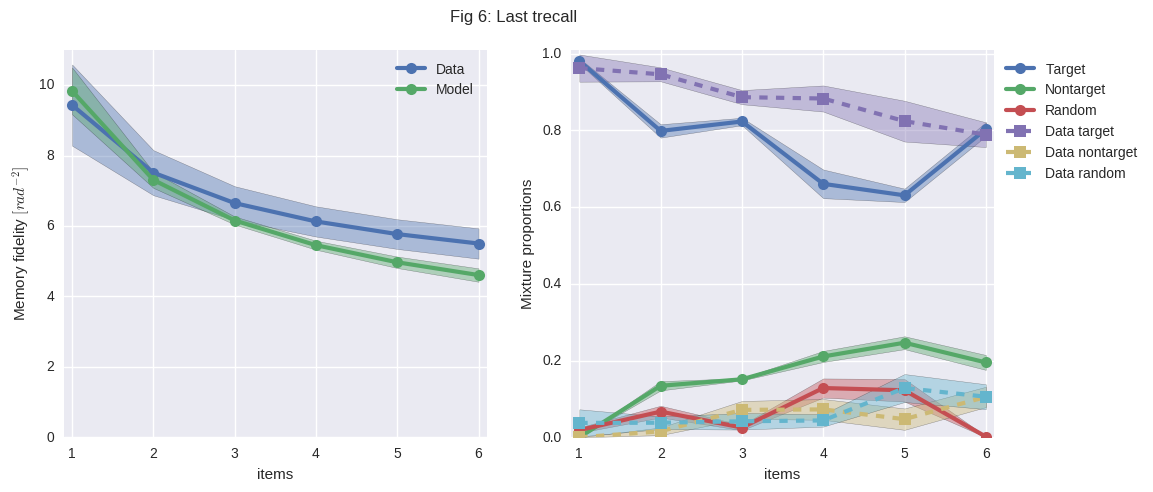

In [17]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig6 = plots_fit_exp.plots_mixtcurves_lasttrecall_fig6(num_repetitions=3, use_cache=True)

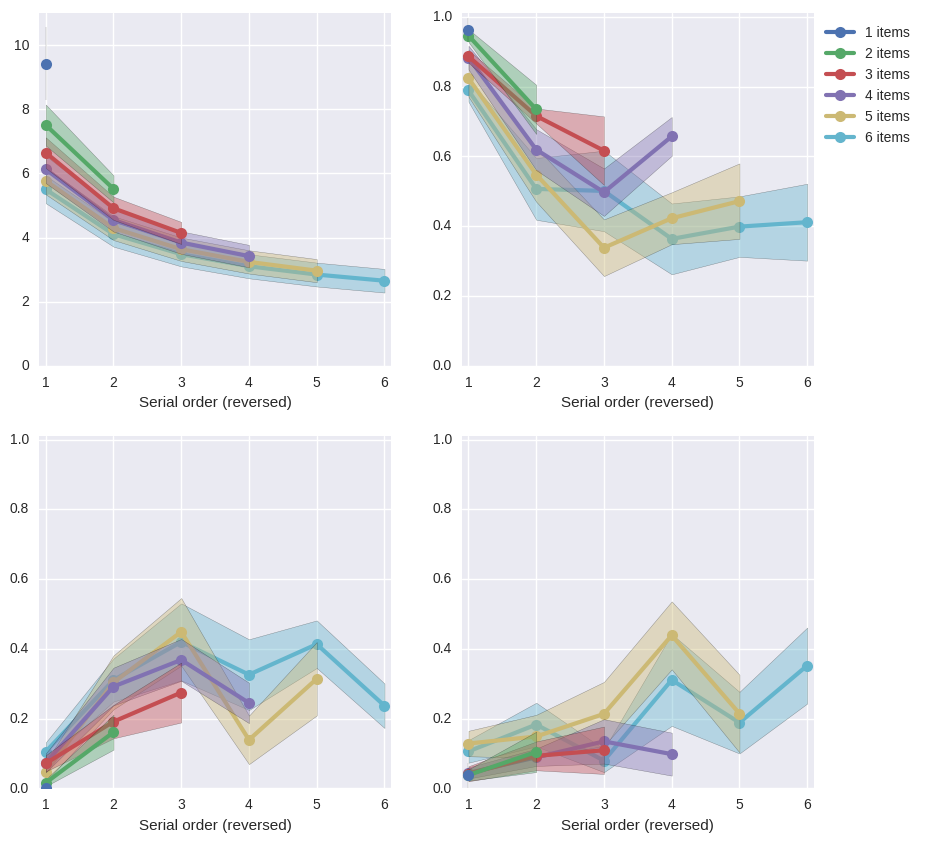

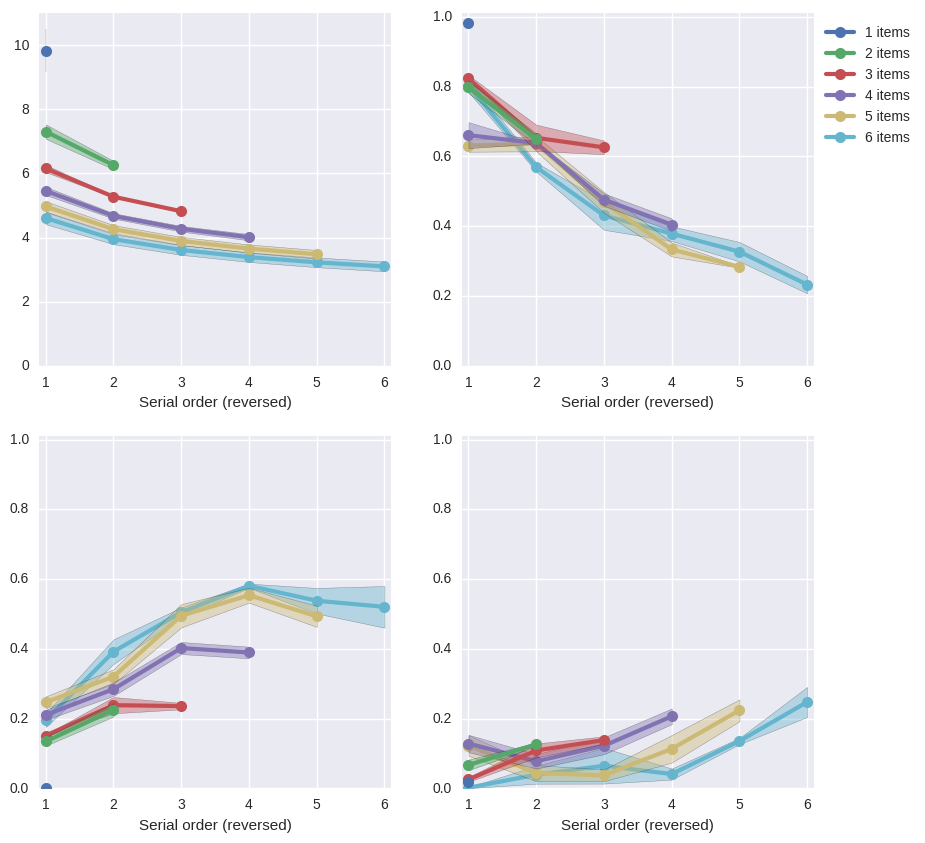

In [18]:
with io.capture_output(display=False, stdout=True) as captured:
    axes_fig7_data, axes_fig7_model = plots_fit_exp.plots_mixtcurves_collapsedpowerlaw_fig7()

# !! ANALYSE ME !!




In [19]:
# Store figures
dataio = DataIO(output_folder=os.path.join(os.path.abspath("."), "outputs"), 
                label='thesis_gorgo11sequential_hier', calling_function='')
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_sigmabaseline_cmaes_08_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_gorgo11sequential_1try_emfitmsescaled_Mratiosigxsigbaselapsealpha_rep3_181018/outputs/thesis_gorgo11sequential_hier-f52272c6-a881-457e-8cc2-106d863eb1a4 ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_gorgo11sequential_1try_emfitmsescaled_Mratiosigxsigbaselapsealpha_rep3_181018/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_sigmabaseline_cmaes_08_2016/fitexperiment_sigmabaseline_cmaes_08_2016_cmaes_hier_gorgo11sequential_1try_emfitmsescaled_Mratiosigxsigbaselapsealpha_rep3_181018
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_gorgo11sequential_1try_emfitmsescaled_Mratiosigxsigbaselapsealpha_rep3_181018/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-ph

In [20]:
# Histograms
axesFig2[0, 0].figure.savefig(dataio.create_formatted_filename("seq_histograms_{label}_{unique_id}.pdf"))
# Fig6, last trecall
axesFig6[0].figure.savefig(dataio.create_formatted_filename("seq_lasttrecall_{label}_{unique_id}.pdf"))
# Fig 7, all times
axes_fig7_data[0, 0].figure.savefig(dataio.create_formatted_filename("seq_alltimes_data_{label}_{unique_id}.pdf"))
axes_fig7_model[0, 0].figure.savefig(dataio.create_formatted_filename("seq_alltimes_model_{label}_{unique_id}.pdf"))
